# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

In [22]:
#!pip install gymnasium
#!pip install gymnasium[classic-control]

In [23]:
#!pip freeze | grep gym

Código básico de importación y funciones de graficación (no modificar)

In [24]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [25]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True


except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v1') #, render_mode='human')
    #env = gym.make('CartPole-v0')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [26]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [27]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [28]:
def choose_action_softmax() -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax
    """

    # TODO: implementar
    pass

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [29]:
def learn_SARSA(
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        q: dict,
        alpha: float,
        gamma: float
) -> None:

    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: Estado actual
        action: Acción tomada en el estado actual
        reward: Recompensa obtenida después de tomar la acción
        next_state: Próximo estado alcanzado después de tomar la acción
        next_action: Próxima acción a tomar en el próximo estado
        q: Diccionario que almacena los valores Q (utilidades) para pares (estado, acción)
        alpha: Tasa de aprendizaje (0 < alpha <= 1)
        gamma: Factor de descuento (0 < gamma <= 1)
    """

    # Obtiene el valor Q actual para el par (estado, acción)
    q_value = q.get((state, action), 0.0)

    # Obtiene el valor Q del próximo estado y próxima acción
    next_q_value = q.get((next_state, next_action), 0.0)

    # Calcula el error TD (diferencia temporal)
    td_error = reward + gamma * next_q_value - q_value

    # Actualiza el valor Q para el par (estado, acción) usando SARSA
    new_q_value = q_value + alpha * td_error

    # Actualiza el valor Q en el diccionario q
    q[(state, action)] = new_q_value


In [30]:
def learn_Q_learning(
        state: int,
        action: int,
        reward: int,
        next_state: int,
        next_action: int,
        q: dict,
        alpha: float,
        gamma: float
        ) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args:
        state: Estado actual
        action: Acción tomada en el estado actual
        reward: Recompensa obtenida después de tomar la acción
        next_state: Próximo estado alcanzado después de tomar la acción
        q: Diccionario que almacena los valores Q (utilidades) para pares (estado, acción)
        alpha: Tasa de aprendizaje (0 < alpha <= 1)
        gamma: Factor de descuento (0 < gamma <= 1)
    """

    # Obtiene el valor Q actual para el par (estado, acción)
    q_value = q.get((state, action), 0.0)

    # Obtiene el valor Q máximo en el próximo estado
    max_next_q_value = max(q.get((next_state, a), 0.0) for a in q.keys())

    # Calcula el error TD (diferencia temporal)
    td_error = reward + gamma * max_next_q_value - q_value

    # Actualiza el valor Q para el par (estado, acción) usando Q-learning
    new_q_value = q_value + alpha * td_error

    # Actualiza el valor Q en el diccionario q
    q[(state, action)] = new_q_value


Finalmente, definimos el método principal de iteraciones.

In [31]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            alpha = hyperparameters["alpha"]
            gamma = hyperparameters["gamma"]
            learning_function(state, action, reward, next_state, next_action, q, alpha, gamma)

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [32]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1.,
    "epsilon": 0.1
   # "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [33]:
reward_mean, timesteps_ep, reward_ep = run(
    learning_function = learn_SARSA,  # Usar SARSA como algoritmo de aprendizaje
    hyperparameters = hyperparameters,
    episodes_to_run = episodes_to_run,
    env=env,
    actions = actions,
    q = q,
    random_state = random_state
)


### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

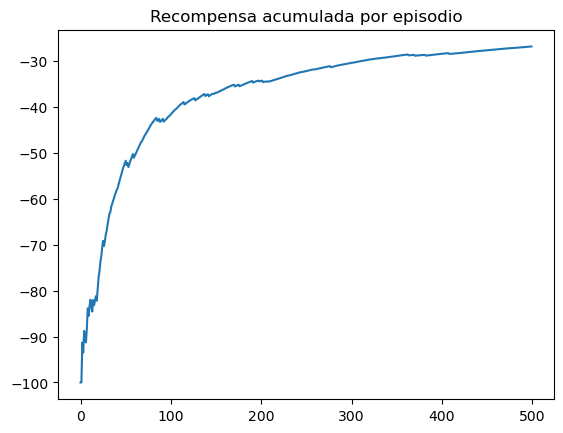

In [34]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

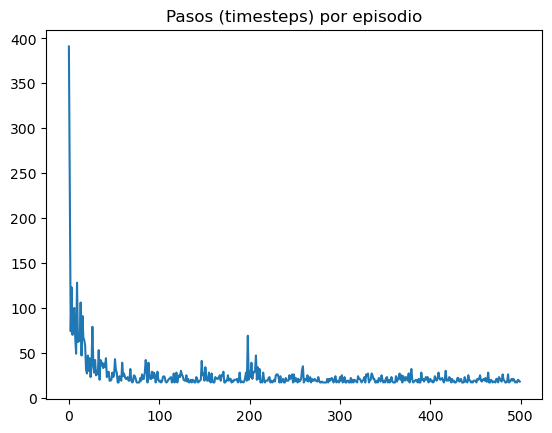

In [35]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

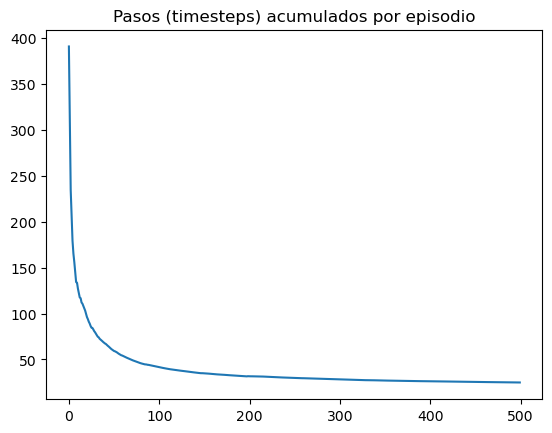

In [36]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

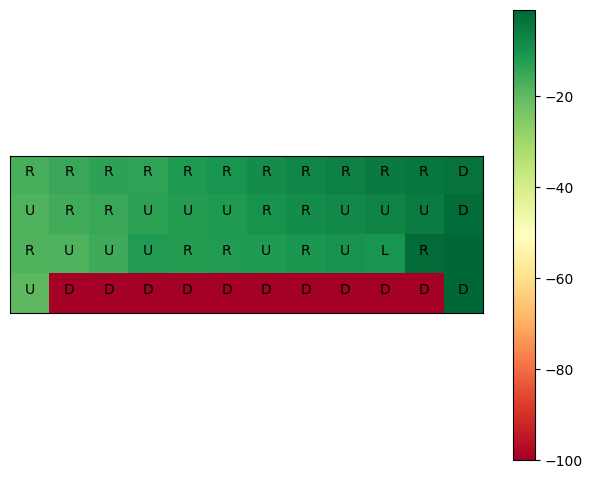


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [37]:
draw_value_matrix(q)

In [38]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN

# Actividades Resueltas:

### Implementación y ejecución del algoritmo SARSA en "The Cliff"

Instanciamos el agente:

In [39]:
def learn_SARSA(
        state: int, # COMPLETAR tipo de cada parámetro
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        q: dict,
        alpha: float,
        gamma: float
) -> None:

    pass

    # Obtiene el valor Q actual para el par (estado, acción)
    q_value = q.get((state, action), 0.0)

    # Obtiene el valor Q del próximo estado y próxima acción
    next_q_value = q.get((next_state, next_action), 0.0)

    # Calcula el error TD (diferencia temporal)
    td_error = reward + gamma * next_q_value - q_value

    # Actualiza el valor Q para el par (estado, acción) usando SARSA
    new_q_value = q_value + alpha * td_error

    # Actualiza el valor Q en el diccionario q
    q[(state, action)] = new_q_value

In [40]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.2,  #tasa de aprendizaje
    "gamma": 0.99,   #factor de descuento
    "epsilon": 0.2  #probabilidad de exploración
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0") #, render_mode='human')
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ejecutamos el agente:

In [41]:
reward_mean, timesteps_ep, reward_ep = run(
    learning_function = learn_SARSA,
    hyperparameters = hyperparameters,
    episodes_to_run = episodes_to_run,
    env = env,
    actions = actions,
    q = q,
    random_state = random_state
)

In [42]:
print('alpha =', hyperparameters['alpha'], 'gamma =', hyperparameters['gamma'], 'espsilon =', hyperparameters['epsilon'])
print('promedio de pasos por episodio =', avg_steps_per_episode)

alpha = 0.2 gamma = 0.99 espsilon = 0.2


NameError: name 'avg_steps_per_episode' is not defined

Veamos la curva de recompensa acumulada:

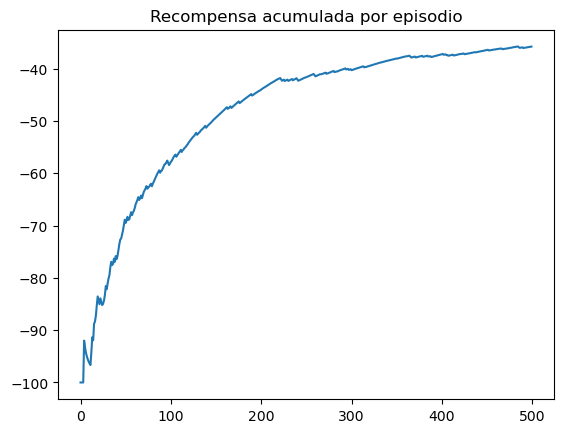

In [ ]:
plot_reward_per_episode(reward_ep)

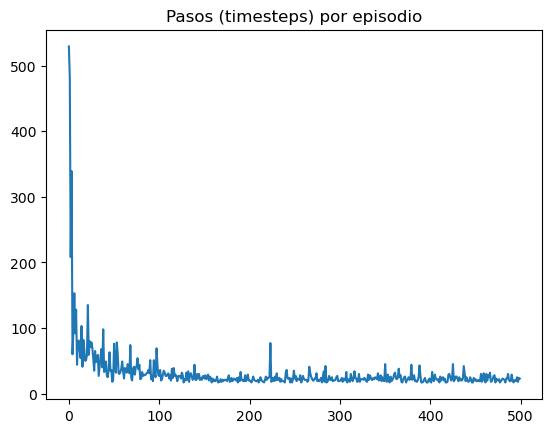

In [ ]:
plot_steps_per_episode(timesteps_ep)

La curva de Por episodio suavizada:

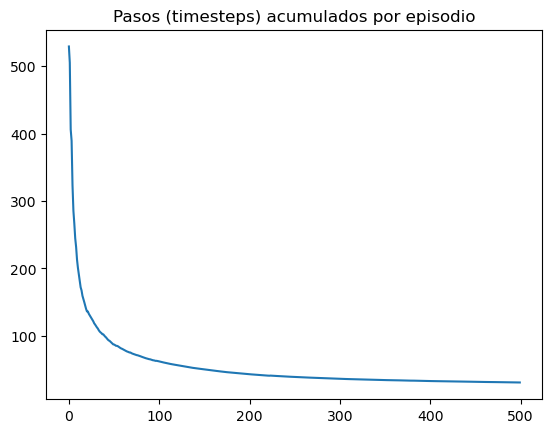

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)

### Implementación y ejecución del algoritmo Q-learn en "The Cliff"

Instanciamos el agente:

In [ ]:
def learn_Q_learning(
        state: int,
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        q: dict,
        alpha: float,
        gamma: float
) -> None:

    pass

    # Obtiene el valor Q actual para el par (estado, acción)
    q_value = q.get((state, action), 0.0)

  # Obtiene el valor Q máximo en el próximo estado (ACA ES donde Q-LEARN diferente con sarsa)
    max_next_q_value = max(q.get((next_state, a), 0.0) for a in q.keys())

    # Calcula el error TD (diferencia temporal)
    td_error = reward + gamma * max_next_q_value - q_value

    # Actualiza el valor Q para el par (estado, acción) usando Q-learning
    new_q_value = q_value + alpha * td_error

    # Actualiza el valor Q en el diccionario q
    q[(state, action)] = new_q_value

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.2,
    "gamma": 0.99,
    "epsilon": 0.2
}

learning_function = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(41)

In [ ]:
# Inicializa el diccionario q con valores predeterminados para todas las posibles combinaciones de estado y acción
q = {(state, action): 0.0 for state in range(env.observation_space.n) for action in actions}

In [ ]:
reward_mean, timesteps_ep, reward_ep = run(
    learning_function = learn_Q_learning,
    hyperparameters = hyperparameters,
    episodes_to_run = episodes_to_run,
    env = env,
    actions = actions,
    q = q,
    random_state = random_state
)

In [ ]:
print('alpha =', hyperparameters['alpha'], 'gamma =', hyperparameters['gamma'], 'espsilon =', hyperparameters['epsilon'])
print('promedio de pasos por episodio =', avg_steps_per_episode)

alpha = 0.2 gamma = 0.99 espsilon = 0.2
promedio de pasos por episodio = -99.91


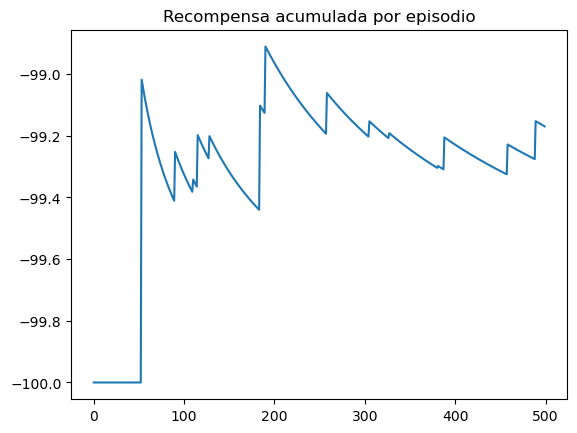

In [ ]:
plot_reward_per_episode(reward_ep)

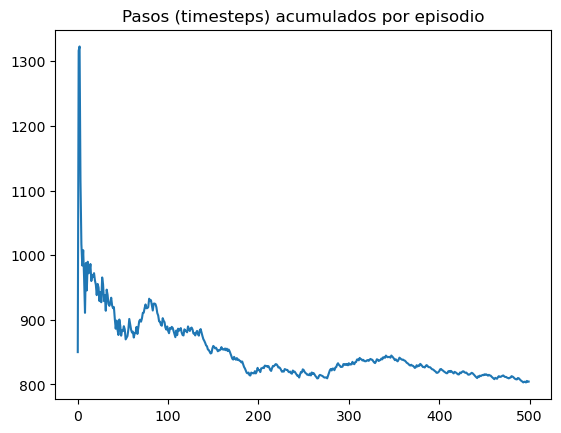

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)

**Comparación**: podemos ver que para el mismo conjunto de hiperparámetros, Q-learn converge mucho más lento...si es que lo hace! mientras sarsaen 500 pasos consigue una recompensa acumulada de -35, q-learn sigue rondando los -100. También vemos que Sarsa consigue disminuir abruptamente los pasos por episodio, llegando a menos de 50, mientras que q-learn no baja de 800.
Es probable que esto se deba a que como q-learn es off-policy puede llevar a sea más propenso a acciones exploratorias arriesgadas, mientras que sarsa al ser on-policy tiende a ser más conservador y seguro, ya que evalúa y mejora la política mientras actúa.
En este caso del CliffWalking, en que caerse del precipicio da una penalidad muy grande, es decir donde es importante evitar caer al precipicio y llegar al objetivo de manera segura, SARSA puede ser más efectivo porque sigue una política más cautelosa y estable durante la exploración y el aprendizaje.

## Análisis de Hiperparámetros

**Alpha** (tasa de aprendizaje):

Determina en qué medida las estimaciones de los valores Q se actualizan después de cada interacción con el entorno. Un valor de alpha alto significa que las estimaciones se actualizan significativamente en cada paso, lo que puede llevar a una convergencia más rápida pero también puede ser inestable. Un valor bajo da lugar a actualizaciones más suaves pero puede llevar más tiempo converger.
Valores: rango de 0 a 1.

**Gamma** (factor de descuento):

Representa la importancia relativa de las recompensas futuras en el proceso de aprendizaje. Un valor de gamma cercano a 1 implica que se consideran fuertemente las recompensas a largo plazo, mientras que un valor cercano a 0 da más peso a las recompensas inmediatas.
Valores:  suele estar en el rango de 0.9 a 0.99.

**Epsilon** (tasa de exploración):

Determina con qué frecuencia el agente toma acciones aleatorias en lugar de seguir su política aprendida. Un valor alto de epsilon implica una alta exploración, lo que significa que el agente intentará muchas acciones aleatorias para descubrir nuevas estrategias. Un valor bajo implica una baja exploración y el agente confía más en las acciones que ha aprendido hasta ahora.
Valores: Suelen estar en el rango de 0.1 a 0.3 para equilibrar entre exploración y explotación.

Vamos a usar el Sarsa para analizar el efecto de cambiar esos hiperparámetros.

 ### **Epsilon**:


Veamos qué ocurre si variamos epsilon, esto la haremos dejando fijo a alpha en 0.2 y a gamma en 0.99.

In [ ]:


# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.2,  #tasa de aprendizaje
    "gamma": 0.99   #factor de descuento
}  

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0") #, render_mode='human')
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

#Ahora vamos a variar el hiperparametro epsilon

epsilon_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Diccionario para almacenar los resultados para cada valor de epsilon
results = {}
for epsilon in epsilon_values:
    q = {}
    # Establecer el valor de epsilon en los hiperparámetros
    hyperparameters["epsilon"] = epsilon

    # Ejecutar el código con el nuevo valor de epsilon
    reward_mean, timesteps_ep, reward_ep = run(
        learning_function = learn_SARSA,
        hyperparameters = hyperparameters,
        episodes_to_run = episodes_to_run,
        env = env,
        actions = actions,
        q = q,
        random_state = random_state
    )

    # Almacenar los resultados para este valor de epsilon
    results[epsilon] = {
        "reward_mean": reward_mean,
        "timesteps_ep": timesteps_ep,
        "reward_ep": reward_ep
    }
   


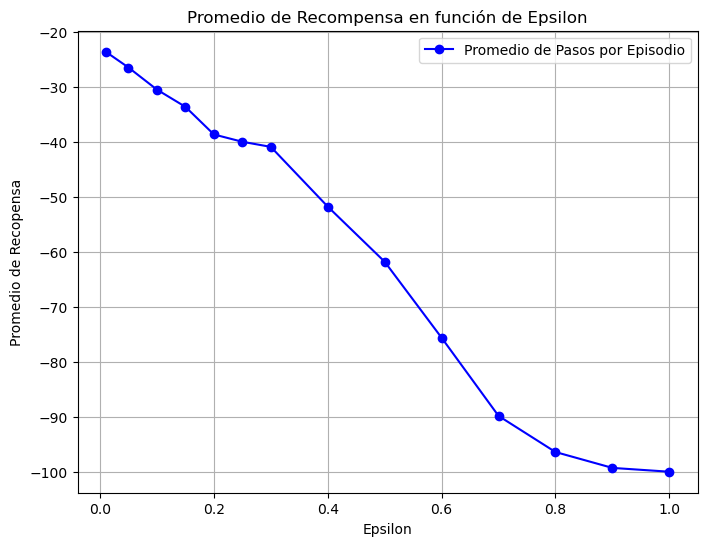

In [ ]:
epsilons = list(results.keys())
Reward_promedio = [result["reward_mean"] for result in results.values()]

plt.figure(figsize=(8, 6))
plt.plot(epsilons, Reward_promedio , marker='o', color='b', label='Promedio de Pasos por Episodio')
plt.xlabel('Epsilon')
plt.ylabel('Promedio de Recopensa')
plt.title('Promedio de Recompensa en función de Epsilon')
plt.legend()
plt.grid(True)
plt.show()

Podemos ver que las mejores recompensas ocurren para epsilon chicos, entre 0,01 y 0,1. Podmeos ver ahora analizando sólo esos valores de epsilon pequeños:

In [ ]:
# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.2,  #tasa de aprendizaje
    "gamma": 0.99   #factor de descuento
}  

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0") #, render_mode='human')
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

#Ahora vamos a variar el hiperparametro epsilon

epsilon_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15]

# Diccionario para almacenar los resultados para cada valor de epsilon
results = {}
for epsilon in epsilon_values:
    q = {}
    # Establecer el valor de epsilon en los hiperparámetros
    hyperparameters["epsilon"] = epsilon

    # Ejecutar el código con el nuevo valor de epsilon
    reward_mean, timesteps_ep, reward_ep = run(
        learning_function = learn_SARSA,
        hyperparameters = hyperparameters,
        episodes_to_run = episodes_to_run,
        env = env,
        actions = actions,
        q = q,
        random_state = random_state
    )

    # Almacenar los resultados para este valor de epsilon
    results[epsilon] = {
        "reward_mean": reward_mean,
        "timesteps_ep": timesteps_ep,
        "reward_ep": reward_ep
    }
   


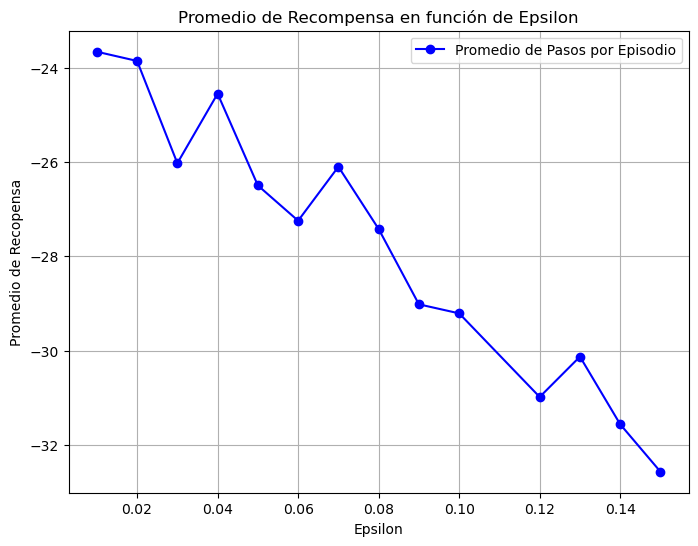

In [ ]:
epsilons = list(results.keys())
Reward_promedio = [result["reward_mean"] for result in results.values()]

plt.figure(figsize=(8, 6))
plt.plot(epsilons, Reward_promedio , marker='o', color='b', label='Promedio de Pasos por Episodio')
plt.xlabel('Epsilon')
plt.ylabel('Promedio de Recopensa')
plt.title('Promedio de Recompensa en función de Epsilon')
plt.legend()
plt.grid(True)
plt.show()

Podemos ver que la recompensa promedio siempre disminuye a medida que aumenta epsilon.
Por lo tanto elefiríamos el epsilon 0.01, peor antes veamos cómo son los pasos por episodios para cada epsilon.  Para ello vamos a ver la curva suavizada:

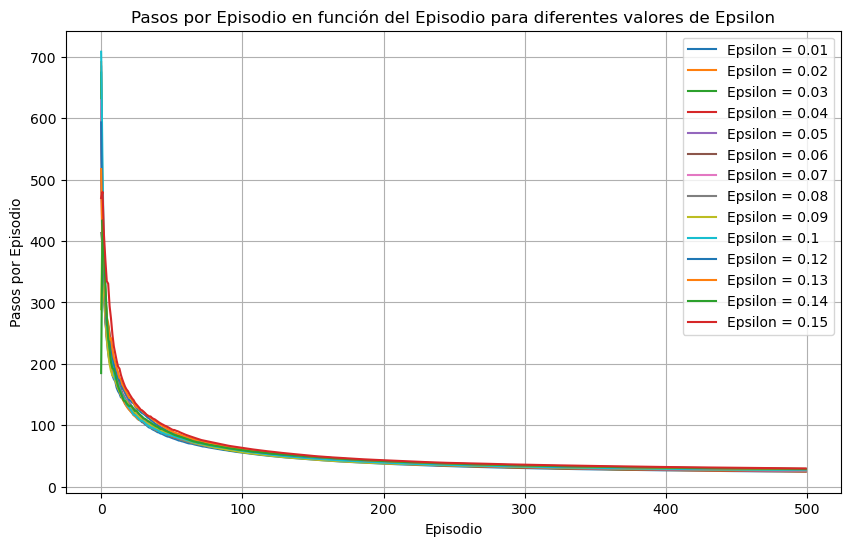

In [ ]:
# Suponiendo que results es el diccionario que contiene los datos
epsilons = list(results.keys())

plt.figure(figsize=(10, 6))

for epsilon in epsilons:
    episode_steps = np.array(results[epsilon]["timesteps_ep"])

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]
    #plot_steps_per_episode_smooth(results[epsilon]["timesteps_ep"])
    #timesteps_ep = results[epsilon]["timesteps_ep"]
    #plt.plot(timesteps_ep, label=f'Epsilon = {epsilon}')
    plt.plot(steps_per_episode, label=f'Epsilon = {epsilon}')

plt.xlabel('Episodio')
plt.ylabel('Pasos por Episodio')
plt.title('Pasos por Episodio en función del Episodio para diferentes valores de Epsilon')
plt.legend()
plt.grid(True)
plt.show()

Pareciera que todas las curvas son muy semejantes, vamos a ver la cantidad de pasos en el último episodio, que es cuando más aprendió:

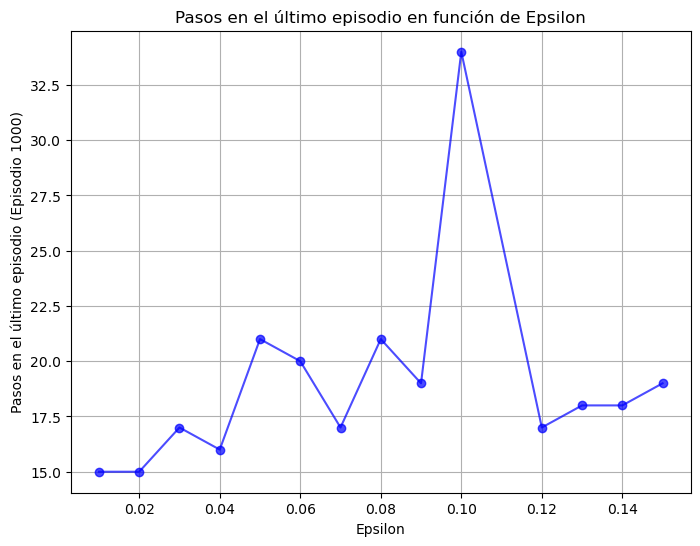

In [ ]:
# Suponiendo que results es el diccionario que contiene los datos
epsilons = list(results.keys())
last_episode_steps = [results[epsilon]["timesteps_ep"][-1] for epsilon in epsilons]

plt.figure(figsize=(8, 6))
plt.plot(epsilons, last_episode_steps, color='blue', marker='o', alpha=0.7)
plt.xlabel('Epsilon')
plt.ylabel('Pasos en el último episodio (Episodio 1000)')
plt.title('Pasos en el último episodio en función de Epsilon')
plt.grid(True)
plt.show()

Podemos ver que para epsilon menores tenemos menos pasos en el último episodio. Por lo tanto para poder variar los otros hyperparámetros usaré **epsilon = 0.01**.  Es decir que tenemos mejores resultados cuando hay poca exploración y el agente utiliza lo aprendido.

### **Gamma** (factor de descuento)

Veamos ahora como resulta de variar gamma, dejando fijos a alpa = 0.02 y a epsilon = 0.01.

In [ ]:
# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.2,  #tasa de aprendizaje
    "epsilon": 0.01   #factor de descuento
}  

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0") #, render_mode='human')
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

#Ahora vamos a variar el hiperparametro epsilon

gammas_values = [0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

# Diccionario para almacenar los resultados para cada valor de epsilon
results_gamma = {}
for gamma in gammas_values:
    q = {}
    # Establecer el valor de epsilon en los hiperparámetros
    hyperparameters["gamma"] = gamma

    # Ejecutar el código con el nuevo valor de epsilon
    reward_mean, timesteps_ep, reward_ep = run(
        learning_function = learn_SARSA,
        hyperparameters = hyperparameters,
        episodes_to_run = episodes_to_run,
        env = env,
        actions = actions,
        q = q,
        random_state = random_state
    )

    # Almacenar los resultados para este valor de epsilon
    results_gamma[gamma] = {
        "reward_mean": reward_mean,
        "timesteps_ep": timesteps_ep,
        "reward_ep": reward_ep
    }
   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


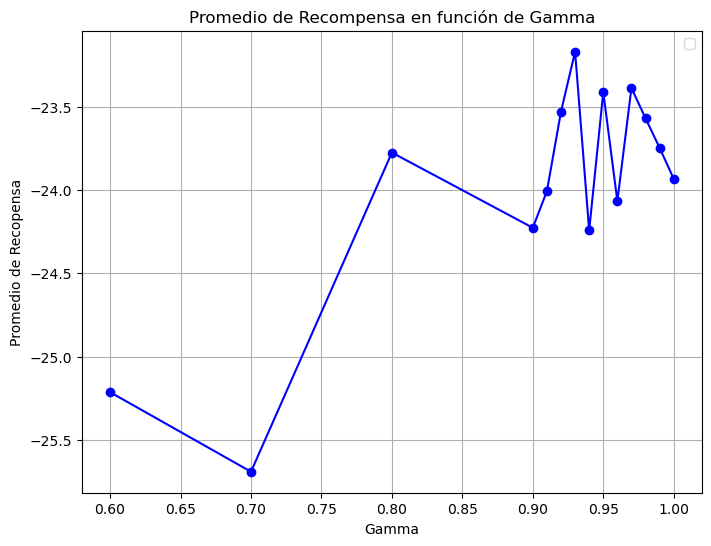

In [ ]:
gammas = list(results_gamma.keys())
Reward_promedio = [results_gamma["reward_mean"] for results_gamma in results_gamma.values()]

plt.figure(figsize=(8, 6))
plt.plot(gammas, Reward_promedio , marker='o', color='b')
plt.xlabel('Gamma')
plt.ylabel('Promedio de Recopensa')
plt.title('Promedio de Recompensa en función de Gamma')
plt.legend()
plt.grid(True)
plt.show()

La recompensa promedio tiene valores uy parecidos en el rango de 0,9 a 1, con un máximo en 0,93.

Veamos los pasos por episodio.

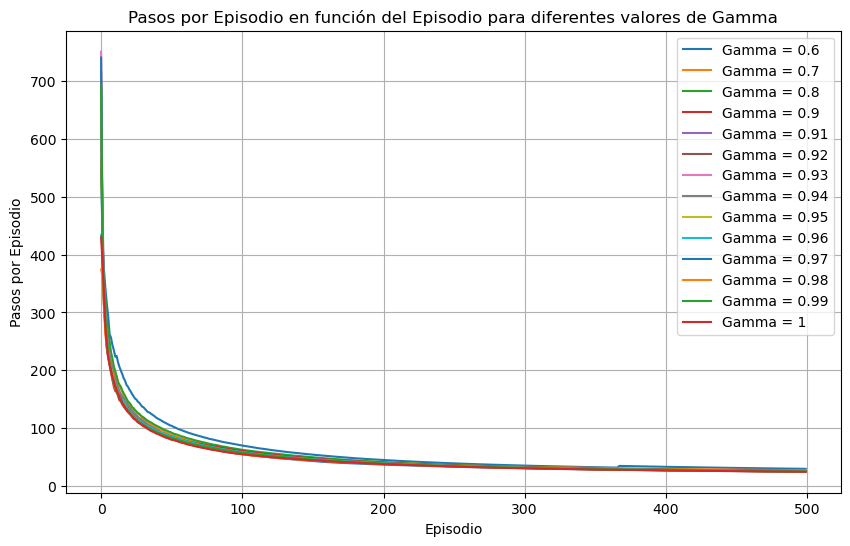

In [ ]:
# Suponiendo que results es el diccionario que contiene los datos
gammas = list(results_gamma.keys())

plt.figure(figsize=(10, 6))

for gamma in gammas:
    episode_steps = np.array(results_gamma[gamma]["timesteps_ep"])

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]
    #plot_steps_per_episode_smooth(results[epsilon]["timesteps_ep"])
    #timesteps_ep = results[epsilon]["timesteps_ep"]
    #plt.plot(timesteps_ep, label=f'Epsilon = {epsilon}')
    plt.plot(steps_per_episode, label=f'Gamma = {gamma}')

plt.xlabel('Episodio')
plt.ylabel('Pasos por Episodio')
plt.title('Pasos por Episodio en función del Episodio para diferentes valores de Gamma')
plt.legend()
plt.grid(True)
#plt.ylim(0, 30)
plt.show()

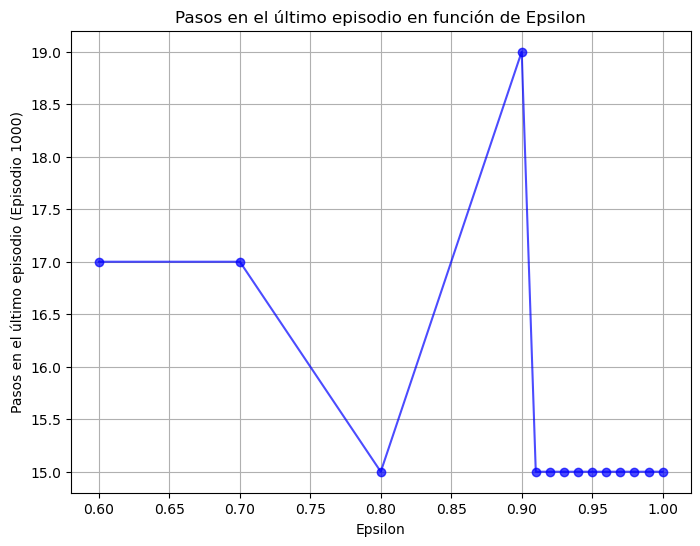

In [ ]:
# Suponiendo que results es el diccionario que contiene los datos
gammass = list(results_gamma.keys())
last_episode_steps = [results_gamma[gamma]["timesteps_ep"][-1] for gamma in gammas]

plt.figure(figsize=(8, 6))
plt.plot(gammas, last_episode_steps, color='blue', marker='o', alpha=0.7)
plt.xlabel('Epsilon')
plt.ylabel('Pasos en el último episodio (Episodio 1000)')
plt.title('Pasos en el último episodio en función de Epsilon')
plt.grid(True)
plt.show()

Vemos que hay a partir de 0,91  todos tienen la misma cantidad de pasos que es 15.

Vamos a elegir **gamma = 0.93**.

### **Alpha** (tasa de aprendizaje)

Veamos por últimmo cómo varía con Alpha dejando fijos gamma = 0.9 y epsilon = 0.01.

In [43]:
# definimos sus híper-parámetros básicos
hyperparameters = {
    "gamma": 0.93,  #tasa de aprendizaje
    "epsilon": 0.01   #factor de descuento
}  

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0") #, render_mode='human')
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

#Ahora vamos a variar el hiperparametro epsilon

alpha_values = [0.01,  0.05, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1]

# Diccionario para almacenar los resultados para cada valor de epsilon
results_alpha = {}
for alpha in alpha_values:
    q = {}
    # Establecer el valor de epsilon en los hiperparámetros
    hyperparameters["alpha"] = alpha

    # Ejecutar el código con el nuevo valor de epsilon
    reward_mean, timesteps_ep, reward_ep = run(
        learning_function = learn_SARSA,
        hyperparameters = hyperparameters,
        episodes_to_run = episodes_to_run,
        env = env,
        actions = actions,
        q = q,
        random_state = random_state
    )

    # Almacenar los resultados para este valor de epsilon
    results_alpha[alpha] = {
        "reward_mean": reward_mean,
        "timesteps_ep": timesteps_ep,
        "reward_ep": reward_ep
    }
   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


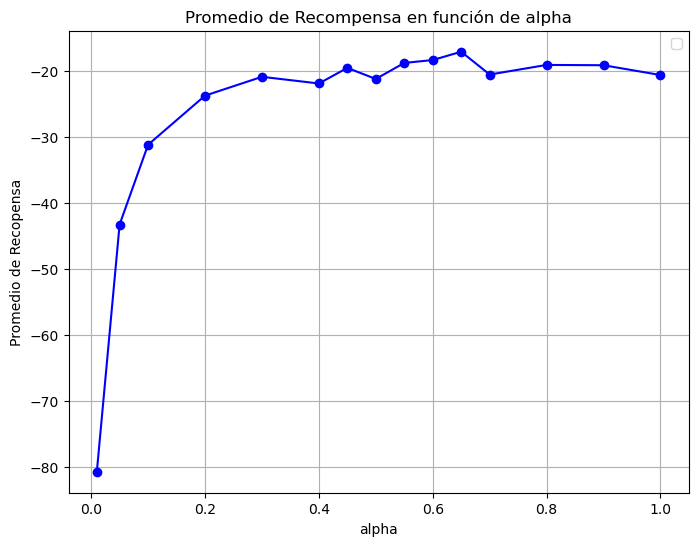

In [44]:
alphas = list(results_alpha.keys())
Reward_promedio = [results_alpha["reward_mean"] for results_alpha in results_alpha.values()]

plt.figure(figsize=(8, 6))
plt.plot(alphas, Reward_promedio , marker='o', color='b')
plt.xlabel('alpha')
plt.ylabel('Promedio de Recopensa')
plt.title('Promedio de Recompensa en función de alpha')
plt.legend()
plt.grid(True)
plt.show()

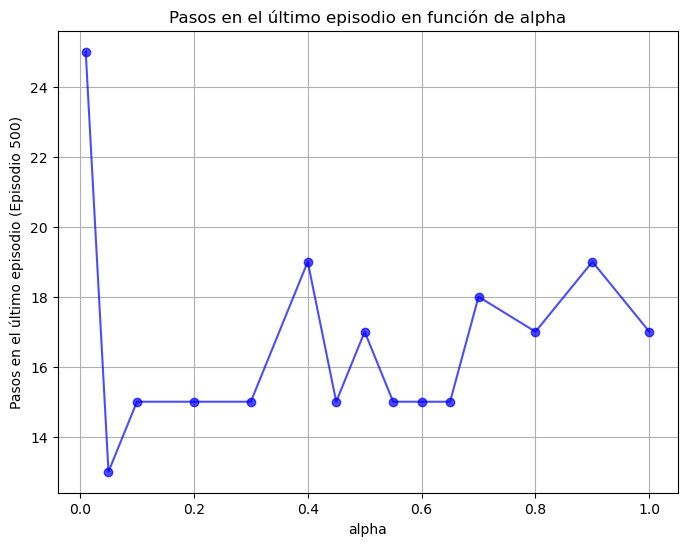

In [45]:
# Suponiendo que results es el diccionario que contiene los datos
alphas = list(results_alpha.keys())
last_episode_steps = [results_alpha[alpha]["timesteps_ep"][-1] for alpha in alphas]

plt.figure(figsize=(8, 6))
plt.plot(alphas, last_episode_steps, color='blue', marker='o', alpha=0.7)
plt.xlabel('alpha')
plt.ylabel('Pasos en el último episodio (Episodio 500)')
plt.title('Pasos en el último episodio en función de alpha')
plt.grid(True)
plt.show()

Vemos que las recompensas más altas están entre 0,5 y 6,5, veamos allí con mas detenimiento.

In [48]:
# definimos sus híper-parámetros básicos
hyperparameters = {
    "gamma": 0.93,  #tasa de aprendizaje
    "epsilon": 0.01   #factor de descuento
}  

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0") #, render_mode='human')
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

#Ahora vamos a variar el hiperparametro epsilon

alpha_values = [0.5, 0.55,  0.60, 0.65, 0.7, 0.75, 0.8, 0.85]

# Diccionario para almacenar los resultados para cada valor de epsilon
results_alpha = {}
for alpha in alpha_values:
    q = {}
    # Establecer el valor de epsilon en los hiperparámetros
    hyperparameters["alpha"] = alpha

    # Ejecutar el código con el nuevo valor de epsilon
    reward_mean, timesteps_ep, reward_ep = run(
        learning_function = learn_SARSA,
        hyperparameters = hyperparameters,
        episodes_to_run = episodes_to_run,
        env = env,
        actions = actions,
        q = q,
        random_state = random_state
    )

    # Almacenar los resultados para este valor de epsilon
    results_alpha[alpha] = {
        "reward_mean": reward_mean,
        "timesteps_ep": timesteps_ep,
        "reward_ep": reward_ep
    }
   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


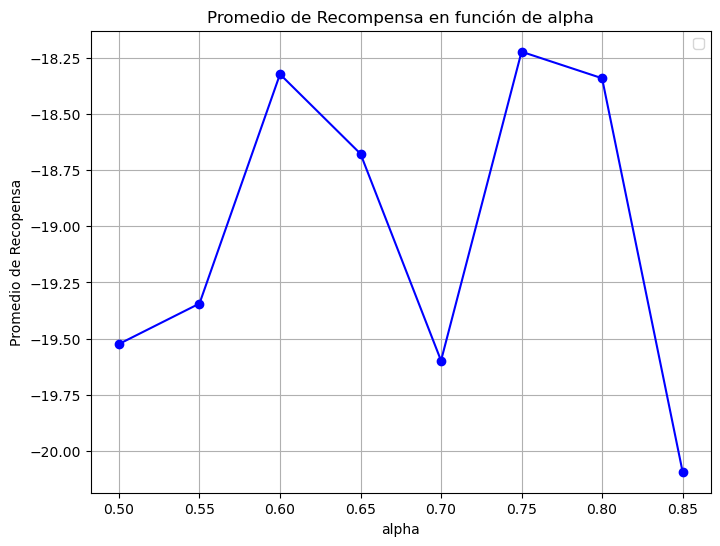

In [49]:
alphas = list(results_alpha.keys())
Reward_promedio = [results_alpha["reward_mean"] for results_alpha in results_alpha.values()]

plt.figure(figsize=(8, 6))
plt.plot(alphas, Reward_promedio , marker='o', color='b')
plt.xlabel('alpha')
plt.ylabel('Promedio de Recopensa')
plt.title('Promedio de Recompensa en función de alpha')
plt.legend()
plt.grid(True)
plt.show()

Vemos que la recompensa promedio tiene muy poca variación en el rango de 0.65 a 0.85, menos a 1 punto.
Veamos los pasos del ultimo episodio.

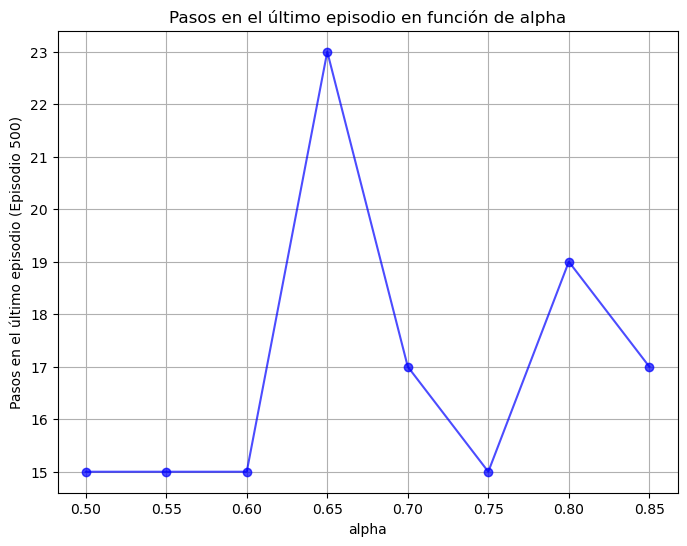

In [50]:
# Suponiendo que results es el diccionario que contiene los datos
alphas = list(results_alpha.keys())
last_episode_steps = [results_alpha[alpha]["timesteps_ep"][-1] for alpha in alphas]

plt.figure(figsize=(8, 6))
plt.plot(alphas, last_episode_steps, color='blue', marker='o', alpha=0.7)
plt.xlabel('alpha')
plt.ylabel('Pasos en el último episodio (Episodio 500)')
plt.title('Pasos en el último episodio en función de alpha')
plt.grid(True)
plt.show()

Podemos tomar como apha = 0.75 ya que tiene menos pasos y más recompensa.

En el problema del CliffWalking, el entorno no cambia con el tiempo por lo que un valor realtivamente alto de alpha puede ayudar al agente a converger hacia una política estable y óptima en ese entorno estático.

Por lo tanto los valores de los hyperparámetros elegidos son:

* **alpha = 0.75**

* **gamma = 0.93**

* **epsilon = 0.01**